In [17]:
import folium
from folium import plugins
import requests
import json
import numpy as np
from pyArango.connection import *
from scipy.spatial.distance import pdist
import os
from time import sleep
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

In [2]:
colors = '#58355e #e03616 #fff689 #cfffb0 #5998c5 #B5FFE1 #93E5AB #65B891 #4E878C #00241B'.split()
colors_for_gradient = '#1BE7FF #6EEB83 #E4FF1A #E8AA14 #FF5714'.split()
color_gradient = dict(zip(np.around(np.linspace(1,0,len(colors_for_gradient)),2),colors_for_gradient))

In [3]:
conn = Connection(username='galvbnk', password='')
db   = conn['capstone']
col  = db['radar']

In [94]:
def check_cached(lat=0.0, lon=0.0, keyword='', meters=500):
    aql = u'''for doc in near('radar', @latt, @lonn, 100, @meters) filter doc.keyword == @keyword return doc'''
    bind_vars = {'latt': lat, 'lonn': lon, 'meters': str(meters), 'keyword': keyword}
    qres = db.AQLQuery(aql, rawResults=False, batchSize=100, bindVars=bind_vars)
    
    return qres.response['result']

In [86]:
qres.response.keys()

[u'code', u'extra', u'cached', u'hasMore', u'result', u'error']

In [100]:
def radar(coords, term, db_col, force=False, radius=20000, key=''):
    params = {'location': '{0},{1}'.format(*coords),
              'radius': radius,
              'keyword': term,
              'key': key}
    root = 'https://maps.googleapis.com/maps/api/place/radarsearch/json'
    
    cached = check_cached(coords[0], coords[1], keyword=term)
    collection = []
    
    if len(cached) > 0 and not force:
        print('Cache hit: {0} {1}'.format(term, coords))
        collection = parse_gresults(cached[0]['response']['results'], params)
    else:
        print('Cache miss: {0} {1}'.format(term, coords))
        print('requesting...')
        r = requests.get(root, params=params)
        if r.status_code == requests.codes.ok:
            print('[OK] status complete')
            collection = parse_gresults(r.json()['results'], params)

            doc = db_col.createDocument(initValues=params)
            doc['location'] = coords
            doc['response'] = r.json()
            doc.save()
            print('cached: complete')

    return collection

In [102]:
def parse_gresults(results, params):
    collection = {'type': 'FeatureCollection', 'features': [] }

    for v in results:
        collection['features'].append({'properties': {'name':params['keyword']}, 'type': 'Feature', 'geometry': { 'type': 'Point',
                       'coordinates': [float(v['geometry']['location']['lng']),float(v['geometry']['location']['lat'])]}})
    return collection

In [103]:
location = [39.7047, -105.0814]

searches = 'grocery;chipotle;college;old chicago;dennys;hospital'.split(';')

res = {}
for search in searches:
    res[search] = radar(location, search, col, radius=25000)
    sleep(1)

Found cached result
Cache hit: grocery [39.7047, -105.0814]
Found cached result
Cache hit: chipotle [39.7047, -105.0814]
Found cached result
Cache hit: college [39.7047, -105.0814]
Found cached result
Cache hit: old chicago [39.7047, -105.0814]
Found cached result
Cache hit: dennys [39.7047, -105.0814]
Found cached result
Cache hit: hospital [39.7047, -105.0814]


In [ ]:
for k,v in res.iteritems():
    print("{0}: {1}".format(k, len(v['features'])))

In [ ]:
wm = folium.Map(location=location, zoom_start=13)
for idx, kv in enumerate(res.itervalues()):
    for feat in kv['features']:
        folium.CircleMarker(location=feat['geometry']['coordinates'][::-1], 
                            radius=2000,
                            fill_opacity=.075,
                            fill_color='#B49FCC',
                            color=None).add_to(wm)
        folium.CircleMarker(location=feat['geometry']['coordinates'][::-1], 
                            radius=200,
                            fill_opacity=1.0,
                            color= colors[idx],
                            fill_color=None).add_to(wm)
wm

In [ ]:
res['chipotle']['features'][0]['geometry']

In [14]:
wm = folium.Map(location=location, zoom_start=13)
dists = {}
for k, v in res.iteritems():
    if k not in ['chipotle']: continue
    ps = [feat['geometry']['coordinates'][::-1] for feat in v['features']]
    dists[k] = pdist(ps, 'euclidean')
    wm.add_children(plugins.HeatMap(data=ps,
                                   blur=30,
                                   radius=90,
                                   gradient=color_gradient,
                                   min_opacity=.47,
                                   max_val=.6,
                                   max_zoom=20))
wm

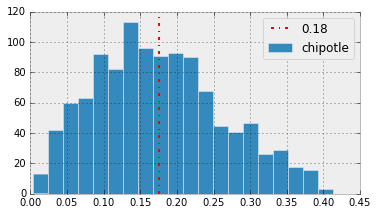

In [104]:
plt.figure(figsize=(13,15))
c = 1
for k,v in dists.iteritems():
    plt.subplot(4,2,c)
    plt.hist(v, bins=20, label=k);
    plt.axvline(v.mean(), c='r', linestyle='-.', label='{0:.2}'.format(v.mean()))
    c += 1
    plt.legend()